In [1]:
import os
import numpy as np
import random
import tensorflow as tf
import pathlib
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras import layers, losses, activations, callbacks, optimizers
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
    

2 Physical GPUs, 2 Logical GPUs


In [2]:
print(tf.__version__)
BATCH_SIZE = 32
EPOCHS = 50

2.3.1


In [3]:
data_path = '../data'
images_dir = pathlib.Path(f'{data_path}/images')
class_names = np.array(sorted([item.name for item in images_dir.glob('*') if item.name != ".gitkeep"]))
print(class_names)
with open(os.path.join(data_path, 'specs.pickle'), 'rb') as f:
    spec_conv, spec_ae = pickle.load(f)

def load(name, spec):
    out_path = os.path.join(data_path, name)
    if not os.path.exists(out_path):
        raise Exception('Path does not exist')
    return tf.data.experimental.load(out_path, spec)

['bad' 'good']


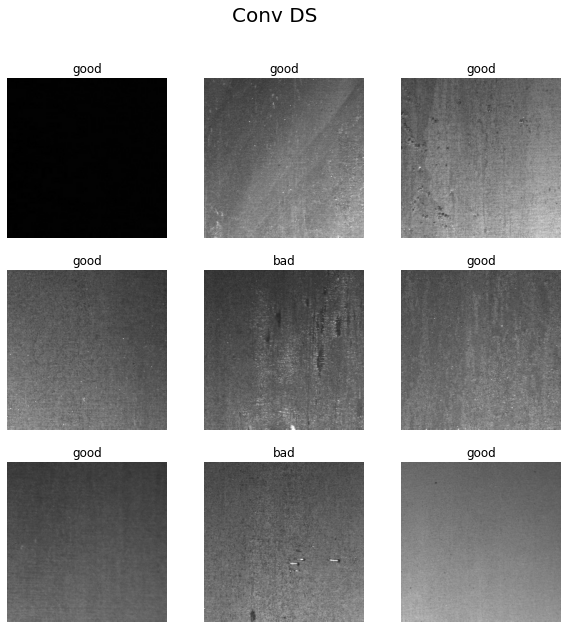

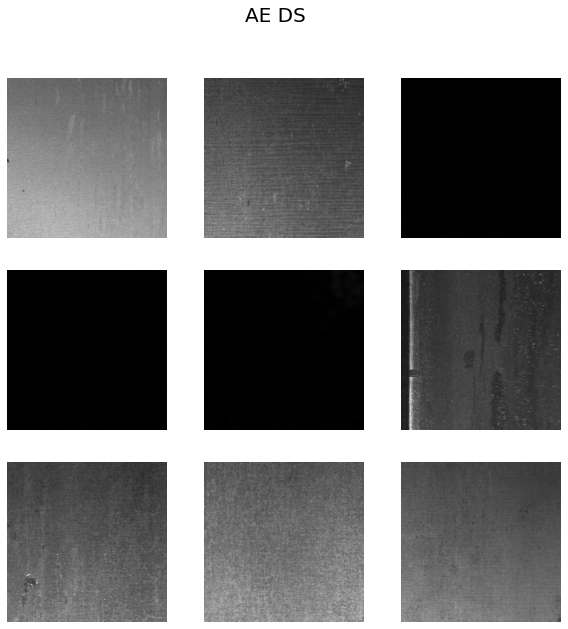

In [4]:
ae_train_ds = load('ae_train_ds', spec_ae)
ae_val_ds = load('ae_val_ds', spec_ae)
conv_train_ds = load('conv_train_ds', spec_conv)
conv_val_ds = load('conv_val_ds', spec_conv)

image_batch, label_batch = next(iter(conv_val_ds))
X_batch, _ = next(iter(ae_val_ds))

def plot_conv_ds(image_batch, label_batch):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle('Conv DS', fontsize=20)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        label = label_batch[i]
        plt.title(class_names[label])
        plt.axis("off")

def plot_ae_ds(image_batch):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle('AE DS', fontsize=20)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")

plot_conv_ds(image_batch, label_batch)
plot_ae_ds(X_batch)

# Autoencoder

In [5]:

class Autoencoder():
    @staticmethod
    def build(width, height, depth, filters=[256,128,64,32], latent_dim=16):
        input_shape = (height, width, depth)
        chan_dim = -1
        
        inputs = layers.Input(shape=input_shape)
        x = inputs
        for f in filters:
            # apply a CONV => RELU => BN operation
            x = layers.Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = layers.LeakyReLU(alpha=0.2)(x)
            x = layers.BatchNormalization(axis=chan_dim)(x)
        
        # flatten the network and then construct our latent vector
        volume_size = K.int_shape(x)
        x = layers.Flatten()(x)
        latent = layers.Dense(latent_dim)(x)
        
        encoder = tf.keras.Model(inputs, latent, name="encoder")
        # start building the decoder model which will accept the
        # output of the encoder as its inputs
        latent_inputs = layers.Input(shape=(latent_dim,))
        x = layers.Dense(np.prod(volume_size[1:]))(latent_inputs)
        x = layers.Reshape((volume_size[1], volume_size[2], volume_size[3]))(x)
        # loop over our number of filters again, but this time in
        # reverse order
        for f in filters[::-1]:
            # apply a CONV_TRANSPOSE => RELU => BN operation
            x = layers.Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
            x = layers.LeakyReLU(alpha=0.2)(x)
            x = layers.BatchNormalization(axis=chan_dim)(x)
        # apply a single CONV_TRANSPOSE layer used to recover the
        # original depth of the image
        x = layers.Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = layers.Activation("sigmoid")(x)
        
        # build the decoder model
        decoder = tf.keras.Model(latent_inputs, outputs, name="decoder")
        
        # our autoencoder is the encoder + decoder
        autoencoder = tf.keras.Model(inputs, decoder(encoder(inputs)),
            name="autoencoder")
        # return a 3-tuple of the encoder, decoder, and autoencoder
        return (encoder, decoder, autoencoder)
        

encoder, decoder, autoencoder = Autoencoder.build(256, 256, 3, [128, 64, 32])


In [6]:
opt = optimizers.Adam(lr=1e-3)
ls = losses.MeanSquaredError()
autoencoder.compile(optimizer=opt, loss=ls, metrics=['accuracy'])

In [7]:
from datetime import datetime

timestamp = datetime.now().isoformat()
outpath = os.path.join('..', 'log')
def get_callbacks():
        tensorboard_dir = os.path.join(outpath, f'tensorboard')
        if not os.path.exists(tensorboard_dir):
            os.makedirs(tensorboard_dir)
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_dir, histogram_freq=1)
        
        metrics_dir = os.path.join(outpath, f'metrics')
        if not os.path.exists(metrics_dir):
            os.makedirs(metrics_dir)
        csv_callback = tf.keras.callbacks.CSVLogger(filename=os.path.join(metrics_dir, f'training_log_{timestamp}.csv'))
        
        checkpoint_dir = os.path.join(outpath, f'checkpoints')
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(verbos=0, 
            filepath=os.path.join(checkpoint_dir, 'weights.{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.hdf5'),
            save_weights_only=False,
            monitor='val_loss',
            mode='auto',
            save_best_only=True,
            save_freq='epoch')

        reduce_lr_plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=3, 
            min_lr=0.00001)

        return [tensorboard_callback, csv_callback, checkpoint_callback, reduce_lr_plateau_callback]

In [8]:
history = autoencoder.fit(ae_train_ds,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                validation_data=ae_val_ds,
                shuffle=True,
                callbacks=get_callbacks())

Epoch 1/50


ResourceExhaustedError:  OOM when allocating tensor with shape[32,128,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node autoencoder/encoder/conv2d/Conv2D (defined at <ipython-input-8-28273312f185>:6) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_2990]

Function call stack:
train_function


In [ ]:
plot_dir = os.path.join(outpath, f'metrics')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
def plot_accuracy(hist):
    plt.clf()
    plt.figure(figsize=(10,10))
    title = f"Accuracy"
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title(title)
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="lower right")
    plt.show(block=False)
    plt.savefig(os.path.join(plot_dir, f'accuracy_{timestamp}.png'))

def plot_loss(hist):
    plt.clf()
    plt.figure(figsize=(10,10))
    title = f"Loss"
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title(title)
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper right")
    plt.show(block=False)
    plt.savefig(os.path.join(plot_dir, f'loss_{timestamp}.png'))
    
def plot_metrics(history, metrics):
    if 'accuracy' in metrics:
        plot_accuracy(hist=history)
    if 'loss' in metrics:
        plot_loss(hist=history)
        
plot_metrics(history, ['accuracy', 'loss'])